In [2]:
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

# Приведение к характеристическому виду

Найдем собственные значения и собственные левые вектора матрицы $A = \begin{pmatrix} 
\frac{5}{8} & \frac{1}{2} & -\frac{47}{8}\\
\frac{1}{4} & 0 & -\frac{11}{4}\\
-\frac{41}{8} & \frac{19}{2} & -\frac{37}{8}
\end{pmatrix}$

In [3]:
A = np.array([[5/8, 1/2, -47/8], 
     [1/4, 0, -11/4],
     [-41/8, 19/2, -37/8]])

In [4]:
sp.linalg.eig(A, left=True, right=False)

(array([ 2.+0.j, -5.+0.j, -1.+0.j]),
 array([[ 0.58834841,  0.40824829, -0.38348249],
        [-0.78446454, -0.81649658,  0.92035799],
        [-0.19611614,  0.40824829, -0.0766965 ]]))

Получим, что $\lambda_1 = 2, \, \, \,\, \omega_1 = (3, -4, -1)^T \\
              \lambda_2 = -5,  \, \omega_2 = (1, -2, 1)^T \\
              \lambda_3 = -1,  \, \omega_3 = (-5, 12, -1)^T $
              
Тогда инварианты Римана будут следующими:

$R_1(x,t) = 3u_1(x,t) - 5u_2(x,t) - u_3(x,t)\\
R_2(x,t) = u_1(x,t) - 2u_2(x,t) + u_3(x,t)\\
R_3(x,t) = -5u_1(x,t) + 12u_2(x,t) - u_3(x,t)$

In [5]:
eig_val = np.array([2, -5, -1])
eig_vect = np.array([[3, -4, -1], 
                     [1, -2, 1],
                     [-5, 12, -1]])
eig_vect_inv = np.linalg.inv(eig_vect)

Так как у нас 2 отрицательных собственных значения, то мы можем поставить корректно граничные условия, если напишем уравнение типа $a_iu_1+b_iu_2+c_iu_3 = \phi_i(t)$, причем не левой границе одно уравнение, а на правой уже два.

Тогда, чтобы узнать $u_1, u_2, u_3$ в точках (0, t) и (1, t) нужно решить следующее равенство:

$\begin{pmatrix} u_1(0, t)\\ u_2(0, t)\\u_3(0, t)\end{pmatrix} = \begin{pmatrix}1&-2&1\\-5&12&-1\\a_3&b_3&c_3 \end{pmatrix}^{-1} \begin{pmatrix} R_2(\frac{t}{5},0)\\R_3(t,0) \\ \phi_3(t)\end{pmatrix} и \begin{pmatrix} u_1(1, t)\\ u_2(1, t)\\u_3(1, t)\end{pmatrix} = \begin{pmatrix}3&-4&-1\\a_1&b_1&c_1\\a_2&b_2&c_2 \end{pmatrix}^{-1} \begin{pmatrix} R_1(1-\frac{t}{2},0)\\ \phi_1(t) \\ \phi_2(t)\end{pmatrix}$

In [6]:
def Init_condition(x):
    return np.array([np.sin(np.pi*x), np.cos(np.pi*x), 1 + np.sin(np.pi*x)])

In [7]:
def phi_1(t):
    return np.sin(np.pi*t)
def phi_2(t):
    return np.cos(np.pi*t)
def phi_3(t):
    return 1+np.sin(np.pi*t)

In [8]:
def R_init(i, x, eig_vect):
    return np.inner(eig_vect[i-1, :], Init_condition(x))

In [9]:
def L_bound_condition(t, eig_vect, k_3, phi_3):
    A = np.array([eig_vect[1, :],
                  eig_vect[2, :],
                  k_3])
    A_inv = np.linalg.inv(A)
    f = np.array([R_init(2, t/5, eig_vect), R_init(3, t, eig_vect), phi_3(t)])
    u = np.dot(A_inv, f)
    return u
def R_bound_condition(t, eig_vect, k_1, k_2, phi_1, phi_2):
    A = np.array([eig_vect[0, :],
                 k_1,
                 k_2])
    A_inv = np.linalg.inv(A)
    f = np.array([R_init(1, 1-t/2, eig_vect), phi_1(t), phi_2(t)])
    u = np.dot(A_inv, f)
    return u

In [56]:
k_1 = [1, 2, 3] #[a1, b1, c1]
k_2 = [4, 5, 6] #[a2, b2, c2]
k_3 = [7, 8, 9] #[a3, b3, c3]

# Cхема Лакса

Есть схема:

$\cfrac{u_m^{n+1} - 0.5(u_{m+1}^n + u_{m-1}^n)}{\tau} + a\cfrac{u_{m+1}^n - u_{m-1}^n}{2h} = 0$

Найдём порядок аппроксимации этой схемы:

$\cfrac{1}{\tau}\left[\left(u + \tau u_{t} + O(\tau^2)\right) - \frac{1}{2}\left(u + hu_x + u - hu_x + O(h^2)\right)\right] + \cfrac{a}{2h}\left[\left(u + hu_x + \frac{h^2}{2}u_{xx} + O(h^3)\right) -\left(u - hu_x + \frac{h^2}{2}u_{xx} + O(h^3)\right)\right] = \\
= u_{\tau} + au_x + O(\tau, \cfrac{h^2}{\tau}, h^2) = O(\tau, \cfrac{h^2}{\tau}, h^2)$

Найдем при каких параметрах $a, \tau, h$ cхема устойчива. 

Подставим $u_m^n = \lambda^n e^{i\omega m}, \sigma = \cfrac{a\tau}{2h}:$

$\lambda - \frac{1}{2}(e^{i\omega m} + e^{-i\omega m}) + \sigma (e^{i\omega m} - e^{-i\omega m}) \Leftrightarrow \lambda = \cos(\omega m) + 2i\sigma \sin(\omega m) \Rightarrow \\
\Rightarrow |\lambda| <= 1 \Leftrightarrow \cos^2(\omega m) + 4\sigma^2 \sin^2(\omega m) <= 1 \Leftrightarrow 4\sigma^2 <=1$

Значит, устойчивость метода не зависит от знака а.

Выпишем ПДП($u_{tt}-a^2u_{xx}=0$):

$\cfrac{1}{\tau}\left(\cfrac{\tau^2}{2}u_{tt}-\cfrac{1}{2}\left(\cfrac{h^2}{2}u_{xx}+\cfrac{h^2}{2}u_{xx}\right)\right) + \cfrac{a}{2h}\left(\cfrac{h^3}{6}u_{xxx}+\cfrac{h^3}{6}u_{xxx}\right) = \left(\cfrac{\tau a^2}{2}-\cfrac{h^2}{2}\right)u_{xx} +\cfrac{ah^2}{6}u_{xxx}$

Посмотрим как схема влияет на волновой пакет ($u_m^n = e^{\lambda n \tau} e^{ikhm}$):

$\cfrac{e^{\lambda\tau} - \frac{1}{2}(e^{ikh} + e^{-ikh})}{\tau} + a \cfrac{e^{ikh} - e^{-ikh}}{2h} = 0 \\
\lambda = \cfrac{1}{\tau}\ln\left[\cos(kh) - i \frac{a\tau}{h}\sin(kh)\right] = \cfrac{1}{\tau}\ln\left[\cos(kh) -i\sigma\sin(kh)\right] = \cfrac{1}{\tau}\ln\left[1 - \frac{(kh)^2}{2} - i \sigma (kh)\right] = \cfrac{1}{\tau}\left(-i\sigma kh - \frac{(kh)^2}{2}-(\sigma kh)^2\right) =\\
=-ika- (kh)^2(\frac{1}{2}+\sigma^2) \Rightarrow \\
\Rightarrow \text{преобладает диссипативная ошибка(второй член отвечает за затухание), схема монотонна(волны движутся с одной скоростью)}$

In [66]:
def Lax(a, X, T, M, N, u_left_bound, u_right_bound, u_init_cond):
    tau = T / N
    h = X / M
    u = np.zeros((N+1, M+1))
    u[:, 0] = u_left_bound
    u[:, -1] = u_right_bound
    u[0, :] = u_init_cond
    sigma = a * tau / 2 / h
    for n in range(0, N):
        for m in range(1, M):
            u[n+1, m] = 1 / 2 * (u[n, m+1] + u[n, m-1]) - sigma * (u[n, m+1] - u[n, m-1])
    return u     

In [67]:
X = 1
T = 1

N_lax = 10000
M_lax = 1000

R = [[] for i in range(3)]
x_range = np.linspace(0, X, M_lax+1)
t_range = np.linspace(0, T, N_lax+1)
for i in range(3):
    R_left_bound = []
    R_right_bound = []
    for k in range(len(t_range)):
        R_left_bound.append(np.inner(eig_vect[i, :], L_bound_condition(t_range[k], eig_vect, k_3, phi_3)))
        R_right_bound.append(np.inner(eig_vect[i, :], R_bound_condition(t_range[k], eig_vect, k_1, k_2, phi_1, phi_2)))
    
    R_init_cond = []
    for k in range(len(x_range)):
        R_init_cond.append(np.inner(eig_vect[i, :], Init_condition(x_range[k])))
    R_init_cond = np.array(R_init_cond)
    
    R[i] = Lax(eig_val[i], X, T, M_lax, N_lax, R_left_bound, R_right_bound, R_init_cond)

u_lax = [np.zeros((N_lax+1, M_lax+1)) for i in range(3)]
for i in range(3):
    for j in range(3):
        u_lax[i] += eig_vect_inv[i, j] * R[j]

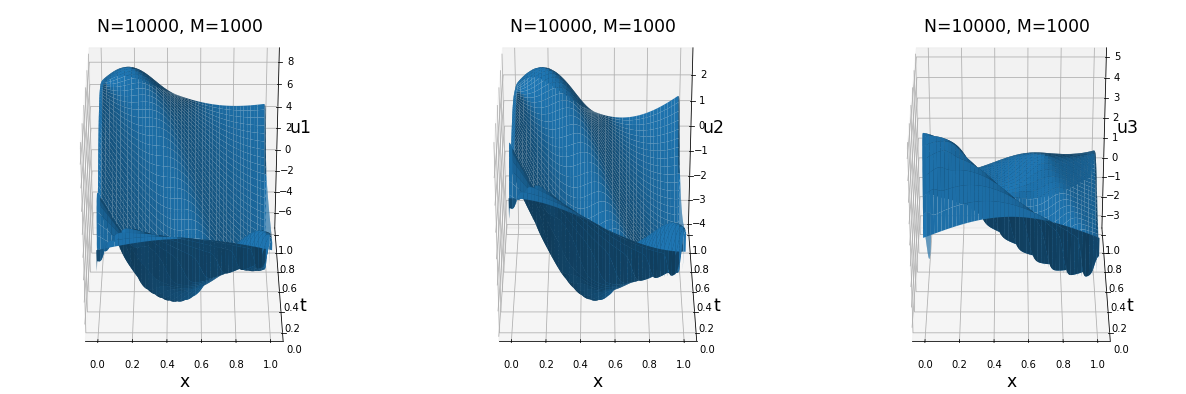

In [68]:
x_for_plot, t_for_plot = np.meshgrid(x_range, t_range)
fig = plt.figure(figsize=(21, 7))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    surf = ax.plot_surface(x_for_plot, t_for_plot, u_lax[i])
    ax.set_xlabel('x', fontsize='xx-large')
    ax.set_ylabel('t', fontsize='xx-large')
    ax.set_zlabel('u{}'.format(i+1), fontsize='xx-large')
    ax.set_title('N={}, M={}'.format(N_lax, M_lax), fontsize='xx-large')
    ax.view_init(30, 270)

Text(0.5, 1.0, 't=20$\\tau$')

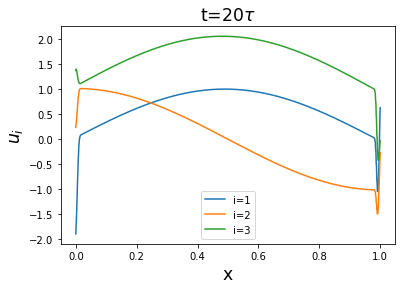

In [74]:
i=20
for k in range(3):
    plt.plot(x_for_plot[i, :], u_lax[k][i, :], label='i={}'.format(k+1))
plt.legend()
plt.ylabel('$u_i$',fontsize='xx-large')
plt.xlabel('x', fontsize='xx-large')
plt.title('t={}$\\tau$'.format(i), fontsize='xx-large')

Text(0.5, 1.0, 'x=10h')

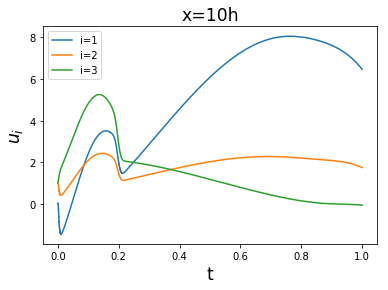

In [73]:
i=10
for k in range(3):
    plt.plot(t_for_plot[:, i], u_lax[k][:, i], label='i={}'.format(k+1))
plt.legend()
plt.ylabel('$u_i$', fontsize='xx-large')
plt.xlabel('t', fontsize='xx-large')
plt.title('x={}h'.format(i), fontsize='xx-large')

Text(0.5, 1.0, 'x=900h')

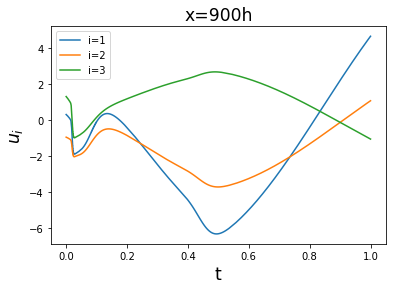

In [72]:
i=900
for k in range(3):
    plt.plot(t_for_plot[:, i], u_lax[k][:, i], label='i={}'.format(k+1))
plt.legend()
plt.ylabel('$u_i$', fontsize='xx-large')
plt.xlabel('t', fontsize='xx-large')
plt.title('x={}h'.format(i), fontsize='xx-large')

### Вывод

Схема монотонна, устойчива, хороша.

# Бегущий счёт

Есть следующая схема:

$\cfrac{1}{2\tau}\left[(u_{m+1}^{n+1} + u_m^{n+1}) - (u_{m+1}^n - u_m^n) \right] + \cfrac{a}{h}\left[(u_{m+1}^{n+1} + u_{m+1}^n) - (u_m^{n+1} - u_m^n)\right] = 0 $

Эта схема не аппроксимирует ничего:

$\cfrac{1}{2\tau}\left[\left(u + \tau u_t + (hu_x + \frac{h^2}{2}u_{xx} + ...) + O(\tau^2, \tau h) + u + \tau u_t + O(\tau^2)\right) - \left(u + (hu_x + \frac{h^2}{2}u_{xx}+ ...) - u\right)\right] + + \cfrac{a}{h}\left[\left(u + (\tau u_t + \frac{\tau^2}{2}u_{tt} + ...) + hu_x + O(h^2, \tau h) + u + hu_x + O(h^2)\right) - \left(u + (\tau u_t + \frac{\tau^2}{2}u_{tt} + ...) - u  \right) \right] = \\
= \cfrac{u}{\tau} + u_{\tau} + O(\tau, h) + \cfrac{2a}{h}u + 2au_x + O(h, \tau) = \cfrac{u}{\tau} + au_x + \cfrac{2a}{h}u + O(\tau, h).$

Подправим схему:

$\cfrac{1}{2\tau}\left[(u_{m+1}^{n+1} + u_m^{n+1}) - (u_{m+1}^n + u_m^n) \right] + \cfrac{a}{2h}\left[(u_{m+1}^{n+1} + u_{m+1}^n) - (u_m^{n+1} + u_m^n)\right] = 0.$

Найдём порядок аппроксимации этой схемы:

$\cfrac{1}{2\tau}\left[\left(u + \tau u_t + (hu_x + \frac{h^2}{2}u_{xx} + ...) + O(\tau^2, \tau h) + u + \tau u_t + O(\tau^2)\right) - \left(u + (hu_x + \frac{h^2}{2}u_{xx}+ ...) + u\right)\right] + + \cfrac{a}{2h}\left[\left(u + (\tau u_t + \frac{\tau^2}{2}u_{tt} + ...) + hu_x + O(h^2, \tau h) + u + hu_x + O(h^2)\right) - \left(u + (\tau u_t + \frac{\tau^2}{2}u_{tt} + ...) + u \right) \right] = \\
= u_{\tau} + O(\tau, h) + au_x + O(h, \tau) = O(\tau, h).$

Найдем при каких параметрах $a, \tau, h$ cхема устойчива. 

Подставим $u_m^n = \lambda^n e^{i\omega m}, \sigma = \cfrac{a\tau}{h}:$

$\left[(\lambda e^{i\omega m} + \lambda) - (e^{i\omega m} + 1)\right] + \sigma \left[ (\lambda e^{i\omega m} + e^{i\omega m}) - (\lambda + 1)\right] = 0 \Leftrightarrow \\
\Leftrightarrow \lambda = \cfrac{(e^{i\omega m} + 1) - \sigma (e^{i\omega m} - 1)}{(e^{i\omega m} + 1) + \sigma (e^{i\omega m} - 1)} = \cfrac{\cos(\frac{\omega m}{2}) - i\sigma\sin(\frac{\omega m}{2})}{\cos(\frac{\omega m}{2}) + i\sigma\sin(\frac{\omega m}{2})} \Rightarrow |\lambda|^2 = \cfrac{\cos^2(\frac{\omega m}{2}) + \sigma^2\sin^2(\frac{\omega m}{2})}{\cos^2(\frac{\omega m}{2}) + \sigma^2\sin^2(\frac{\omega m}{2})} = 1 \Rightarrow \text{метод устойчив при всех } \sigma.$

Аналогичный анализ(что и в первом методе) показывает, что ошибка преобладает также диссипативная, а скорость волн в волновом пакете одна и та же, то есть схема монотонна.


In [11]:
def Running_count(a, X, T, M, N, u_left_bound, u_right_bound, u_init_cond):
    tau = T / N
    h = X / M
    u = np.zeros((N+1, M+1))
    u[0, :] = u_init_cond
    u[:, 0] = u_left_bound
    u[:, -1] = u_right_bound
    sigma = tau * a / h
    if a > 0 :
        for n in range(0, N):
            for m in range(0, M-1):
                u[n+1, m+1] = 1 / (1 + sigma) * (-u[n+1, m] + (u[n, m+1] + u[n, m]) \
                                                 + sigma * (-u[n, m+1] + (u[n+1, m] + u[n, m])))
    elif a < 0:
        for n in range(0, N):
            for m in range(M-1, 1, -1):
                u[n+1, m] = 1 / (1 - sigma) * (-u[n+1, m+1] + (u[n, m+1] + u[n, m]) \
                                                 - sigma * (-u[n, m] + (u[n+1, m+1] + u[n, m+1])))
    return u

In [57]:
X = 1
T = 1

N_run = 1000
M_run = 10000

R = [[] for i in range(3)]
x_range = np.linspace(0, X, M_run+1)
t_range = np.linspace(0, T, N_run+1)
for i in range(3):
    R_left_bound = []
    R_right_bound = []
    for k in range(len(t_range)):
        R_left_bound.append(np.inner(eig_vect[i, :], L_bound_condition(t_range[k], eig_vect, k_3, phi_3)))
        R_right_bound.append(np.inner(eig_vect[i, :], R_bound_condition(t_range[k], eig_vect, k_1, k_2, phi_1, phi_2)))
    
    R_init_cond = []
    for k in range(len(x_range)):
        R_init_cond.append(np.inner(eig_vect[i, :], Init_condition(x_range[k])))
    R_init_cond = np.array(R_init_cond)
    
    R[i] = Running_count(eig_val[i], X, T, M_run, N_run, R_left_bound, R_right_bound, R_init_cond)
    #np.savetxt("Rq{}".format(i), R, newline=' ')
    #R = None
u_run = [np.zeros((N_run+1, M_run+1)) for i in range(3)]
for i in range(3):
    for j in range(3):
        u_run[i] += eig_vect_inv[i, j] * R[j]

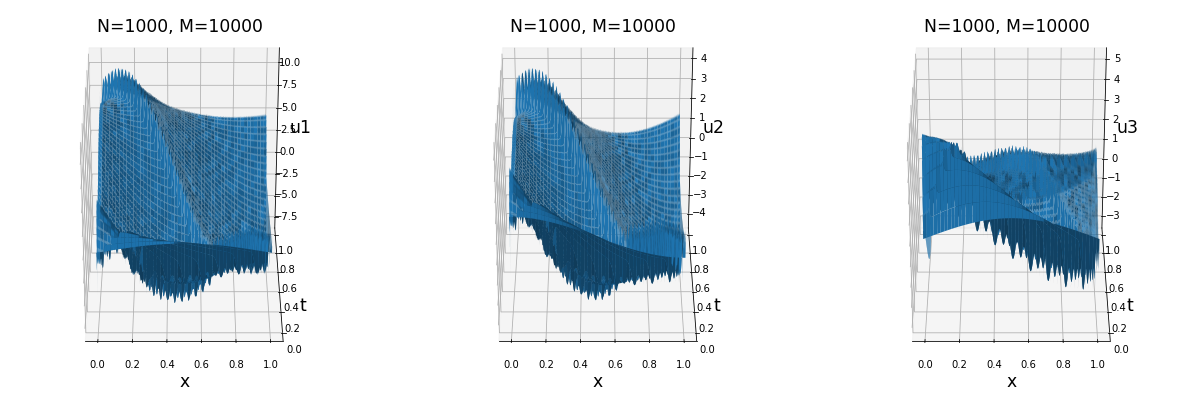

In [58]:
x_for_plot, t_for_plot = np.meshgrid(x_range, t_range)
fig = plt.figure(figsize=(21, 7))
for i in range(3):
    #R = np.fromfile('R{}'.format(i), sep=' ').reshape(N_run+1, M_run+1)
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    surf = ax.plot_surface(x_for_plot, t_for_plot, u_run[i])
    ax.set_xlabel('x', fontsize='xx-large')
    ax.set_ylabel('t', fontsize='xx-large')
    ax.set_zlabel('u{}'.format(i+1), fontsize='xx-large')
    ax.set_title('N={}, M={}'.format(N_run, M_run), fontsize='xx-large')
    ax.view_init(30,270)

Text(0.5, 1.0, 't=20$\\tau$')

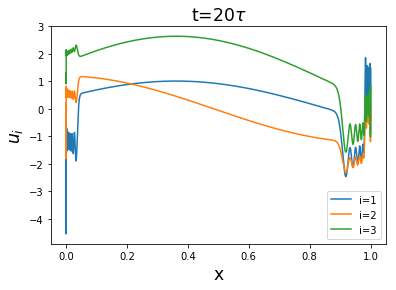

In [59]:
i=20
for k in range(3):
    plt.plot(x_for_plot[i, :], u_run[k][i, :], label='i={}'.format(k+1))
plt.legend()
plt.ylabel('$u_i$',fontsize='xx-large')
plt.xlabel('x', fontsize='xx-large')
plt.title('t={}$\\tau$'.format(i), fontsize='xx-large')

Text(0.5, 1.0, 'x=10h')

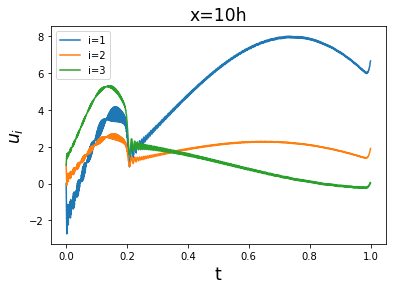

In [62]:
i=10
for k in range(3):
    plt.plot(t_for_plot[:, i], u_run[k][:, i], label='i={}'.format(k+1))
plt.legend()
plt.ylabel('$u_i$', fontsize='xx-large')
plt.xlabel('t', fontsize='xx-large')
plt.title('x={}h'.format(i), fontsize='xx-large')

Text(0.5, 1.0, 'x=9000h')

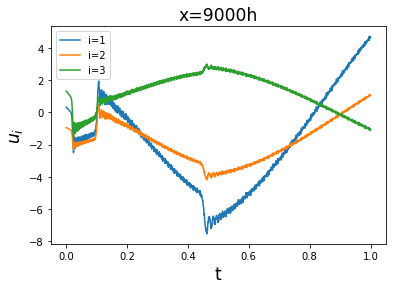

In [63]:
i=9000
for k in range(3):
    plt.plot(t_for_plot[:, i], u_run[k][:, i], label='i={}'.format(k+1))
plt.legend()
plt.ylabel('$u_i$', fontsize='xx-large')
plt.xlabel('t', fontsize='xx-large')
plt.title('x={}h'.format(i), fontsize='xx-large')

### Вывод

Видим, что в с решении есть шумовые колебания, так как схема монотонна, то причиной может являться плохая аппроксимация схемы, а также нестрогое выполнение условия устойчивости $|\lambda| = 1$. Но визуально решение похоже на решение первым методом.